# Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from scipy.io import mmread
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans

In [ ]:
gene_by_cell_comb = pd.read_csv("drive/MyDrive/pbmc_tutorial/gene_by_cell_comb.csv").set_index("Unnamed: 0").sort_index()
reg_by_cell_comb = pd.read_csv("drive/MyDrive/pbmc_tutorial/reg_by_cell_comb.csv").set_index("Unnamed: 0").sort_index()
motif_by_cell_comb = pd.read_csv("drive/MyDrive/pbmc_tutorial/motif_by_cell_comb.csv").set_index("Unnamed: 0").sort_index()
rna_data = gene_by_cell_comb
atac_data = reg_by_cell_comb
motif_data = motif_by_cell_comb

In [ ]:
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
'''Use for 3 data modalities'''

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans

class VAE(keras.Model):
    def __init__(self, input_dim1, input_dim2, input_dim3, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim1 = input_dim1
        self.input_dim2 = input_dim2
        self.input_dim3 = input_dim3  
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.encoder1 = self.encoder1()
        self.encoder2 = self.encoder2()
        self.encoder3 = self.encoder3() 
        self.decoder1 = self.decoder1()
        self.decoder2 = self.decoder2()
        self.decoder3 = self.decoder3() 
        self.model = self.vae()

    def sampling(self, args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], self.latent_dim))
        return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

    def encoder1(self):
        inputs = layers.Input(shape=(self.input_dim1,))
        x = layers.Dense(self.hidden_dim, activation='relu')(inputs)
        x = layers.Dense(self.hidden_dim // 2, activation='relu')(x)
        z_mean = layers.Dense(self.latent_dim, name="rna_z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="rna_log_var")(x)
        z = Lambda(self.sampling)([z_mean, z_log_var])
        return Model(inputs, [z_mean, z_log_var, z], name='encoder_rna')

    def encoder2(self):
        inputs = layers.Input(shape=(self.input_dim2,))
        x = layers.Dense(self.hidden_dim, activation='relu')(inputs)
        x = layers.Dense(self.hidden_dim // 2, activation='relu')(x)
        z_mean = layers.Dense(self.latent_dim, name="atac_z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="rna_log_var")(x)
        z = Lambda(self.sampling)([z_mean, z_log_var])
        return Model(inputs, [z_mean, z_log_var, z], name='encoder_atac')

    def encoder3(self):
        inputs = layers.Input(shape=(self.input_dim3,))
        x = layers.Dense(self.hidden_dim, activation='relu')(inputs)
        x = layers.Dense(self.hidden_dim // 2, activation='relu')(x)
        z_mean = layers.Dense(self.latent_dim, name="tf_z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="tf_log_var")(x)

        z = Lambda(self.sampling)([z_mean, z_log_var])
        return Model(inputs, [z_mean, z_log_var, z], name='encoder_tf')

    def decoder1(self):
        latent_inputs = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(self.hidden_dim // 2, activation='relu')(latent_inputs)
        x = layers.Dense(self.hidden_dim, activation='relu')(x)
        outputs = layers.Dense(self.input_dim1)(x)
        return Model(latent_inputs, outputs, name='decoder_rna')

    def decoder2(self):
        latent_inputs = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(self.hidden_dim // 2, activation='relu')(latent_inputs)
        x = layers.Dense(self.hidden_dim, activation='relu')(x)
        outputs = layers.Dense(self.input_dim2)(x)
        return Model(latent_inputs, outputs, name='decoder_atac')

    def decoder3(self):
        latent_inputs = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(self.hidden_dim // 2, activation='relu')(latent_inputs)
        x = layers.Dense(self.hidden_dim, activation='relu')(x)
        outputs = layers.Dense(self.input_dim3)(x)
        return Model(latent_inputs, outputs, name='decoder_tf')

    def vae(self):
        inputs1 = layers.Input(shape=(self.input_dim1,))
        inputs2 = layers.Input(shape=(self.input_dim2,))
        inputs3 = layers.Input(shape=(self.input_dim3,)) 
        z_mean1, z_log_var1, z1 = self.encoder1(inputs1)
        z_mean2, z_log_var2, z2 = self.encoder2(inputs2)
        z_mean3, z_log_var3, z3 = self.encoder3(inputs3)  

        reconstructed1 = self.decoder1(z1)
        reconstructed2 = self.decoder2(z2)
        reconstructed3 = self.decoder3(z3)  

        reconstructed = Concatenate()([reconstructed1, reconstructed2, reconstructed3])

        vae = Model(inputs=[inputs1, inputs2, inputs3], outputs=[reconstructed])  

        kl_loss1 = -0.5 * tf.reduce_mean(1 + z_log_var1 - tf.square(z_mean1) - tf.exp(z_log_var1), axis=-1)
        kl_loss2 = -0.5 * tf.reduce_mean(1 + z_log_var2 - tf.square(z_mean2) - tf.exp(z_log_var2), axis=-1)
        kl_loss3 = -0.5 * tf.reduce_mean(1 + z_log_var3 - tf.square(z_mean3) - tf.exp(z_log_var3), axis=-1)

        vae.add_loss(tf.keras.backend.mean(kl_loss1 + kl_loss2 + kl_loss3))
        reconstruction_loss1 = tf.reduce_mean(tf.square(inputs1 - reconstructed1), axis=-1)
        reconstruction_loss2 = tf.reduce_mean(tf.square(inputs2 - reconstructed2), axis=-1)
        reconstruction_loss3 = tf.reduce_mean(tf.square(inputs3 - reconstructed3), axis=-1)
        vae.add_loss(tf.keras.backend.mean(reconstruction_loss1 + reconstruction_loss2 + reconstruction_loss3))

        return vae


In [ ]:

# x1 = gene_by_cell_comb
# x2 = reg_by_cell_comb
# x3 = motif_by_cell_comb
# x1 = x1.set_index("Unnamed: 0")
# x2 = x2.set_index("Unnamed: 0")
# x3 = x3.set_index("Unnamed: 0")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x1 = scaler.fit_transform(gene_by_cell_comb).T
scaler = StandardScaler()
x2 = scaler.fit_transform(reg_by_cell_comb).T
scaler = StandardScaler()
x3 = scaler.fit_transform(motif_by_cell_comb).T

In [ ]:
vae = VAE(input_dim1=x1.shape[1], input_dim2=x2.shape[1], input_dim3=x3.shape[1], hidden_dim=512, latent_dim=2000)

In [ ]:
vae.encoder1.compile(optimizer='adam')
vae.decoder1.compile(optimizer='adam', loss='mse')
z1_mean, z1_log_var, z1 = vae.encoder1.predict(x1.astype('float32'))
vae.decoder1.fit(z1, x1.astype('float32'), epochs=100, batch_size=32)

vae.encoder2.compile(optimizer='adam')
vae.decoder2.compile(optimizer='adam', loss='mse')
z2_mean, z2_log_var, z2 = vae.encoder2.predict(x2.astype('float32'))
vae.decoder2.fit(z2, x2.astype('float32'), epochs=100, batch_size=32)

vae.encoder3.compile(optimizer='adam')
vae.decoder3.compile(optimizer='adam', loss='mse')
z3_mean, z3_log_var, z3 = vae.encoder3.predict(x3.astype('float32'))
vae.decoder3.fit(z3, x3.astype('float32'), epochs=100, batch_size=32)


1/1 [==============================] - 0s 78ms/step
Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.0175
Epoch 2/100
1/1 [==============================] - 0s 8ms/step - loss: 0.9226
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 0.7794
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6587
Epoch 5/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6466
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 0.4937
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: 0.4134
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3724
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3308
Epoch 10/100
1/1 [==============================] - 0s 7ms/step - loss: 0.2955
Epoch 11/100
1/1 [==============================] - 0s 7ms/step - loss: 0.2659
Epoch 12/100
1/1 [==============================] - 0s 8ms/step - loss: 0.2247
Epoch 13/1

In [ ]:
from sklearn.cluster import KMeans
latent_data = np.concatenate((z1, z2, z3), axis=1).T
num_clusters = 8 
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(latent_data)
plt.scatter(latent_data[:, 0], latent_data[:, 1], c=kmeans)
plt.legend()
plt.show()

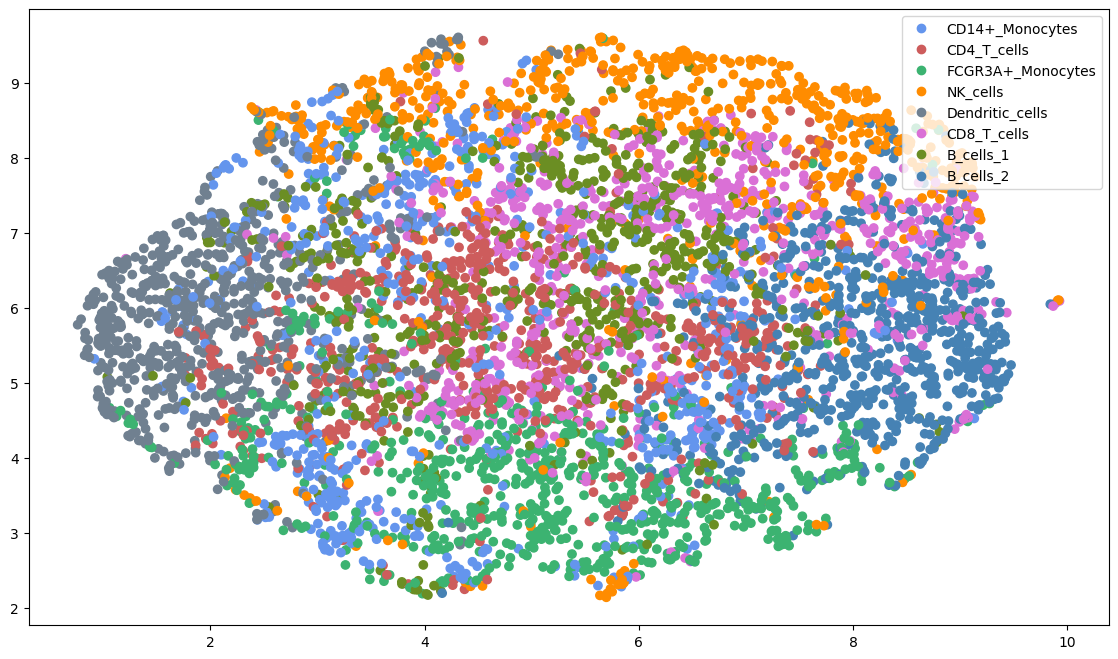

In [ ]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from matplotlib.colors import ListedColormap

cluster_to_celltype = {
    0: 'CD14+_Monocytes',
    1: 'CD4_T_cells',
    2: 'FCGR3A+_Monocytes',
    3: 'NK_cells',
    4: 'Dendritic_cells',
    5: 'CD8_T_cells',
    6: 'B_cells_1',
    7: 'B_cells_2'
}
colors = ["cornflowerblue", "indianred", "mediumseagreen", "darkorange", "slategray", "orchid", "olivedrab", "steelblue"]
cmap = ListedColormap(colors)

combined_latent = np.concatenate((z1, z2, z3), axis=1)
X = combined_latent.T
y = gene_by_cell_comb.columns.values

embedding = umap.UMAP(n_neighbors=8, random_state=0).fit_transform(X)

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(embedding[:, 0], embedding[:, 1], c = kmeans, cmap = cmap)

handles = {cluster: plt.plot([],[], marker="o", ls="", mec=None, color=colors[cluster], 
                             label=cluster_to_celltype[cluster])[0] for cluster in cluster_to_celltype.keys()}

plt.legend(handles=handles.values(), loc='upper right')
plt.subplots_adjust(right=0.8)
#plt.colorbar()
plt.show()

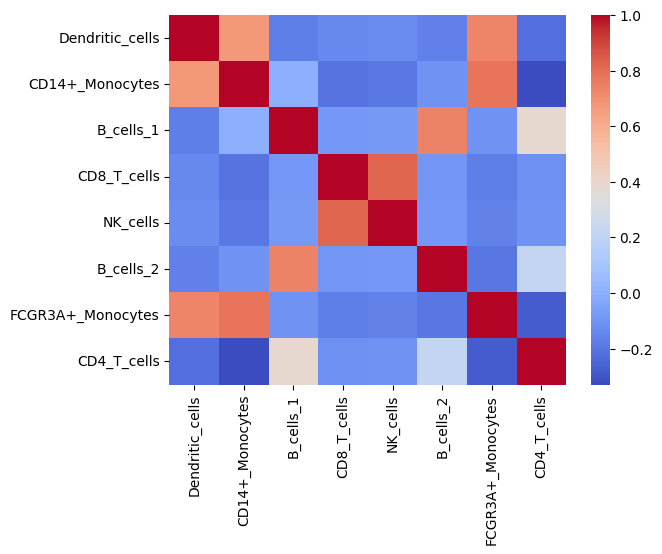

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = motif_by_cell_comb
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.show()
